### Install libraries


In [ ]:
!pip install -r ../dev-requirements.txt

### Load Data

In [15]:
import pandas as pd
import os

folder = os.path.join("../data")
dfs = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(folder, file), skiprows=1, parse_dates=['date']))
print(dfs.__len__())

# For the first dataframe, print summary, info, and head
print(dfs[0].describe())
print(dfs[0].info())
print(dfs[0].head())

24
               unix                           date         open         high  \
count  7.595000e+03                           7595  7595.000000  7595.000000   
mean   1.645029e+09  2022-02-16 16:37:50.915075584    29.022282    29.255667   
min    1.628780e+09            2021-08-12 15:00:00     2.900000     2.900000   
25%    1.635709e+09            2021-10-31 19:30:00    15.715000    15.787100   
50%    1.643256e+09            2022-01-27 04:00:00    22.441000    22.616900   
75%    1.650829e+09            2022-04-24 19:30:00    44.632600    44.836300   
max    1.696108e+09            2023-09-30 21:00:00   346.500000   499.000000   
std    1.192431e+07                            NaN    19.383015    20.225280   

               low        close    Volume ICP     Volume USD  
count  7595.000000  7595.000000   7595.000000    7595.000000  
mean     28.800396    28.991883    193.303991    7999.042266  
min       2.800000     2.887000      0.009011       0.034204  
25%      15.654550    15

### Merge all data into one dataframe

In [47]:
import pandas as pd

# Step 1: Convert "date" column to datetime in all dataframes
for df in dfs:
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors="coerce")

# Step 2: Find the oldest and newest dates across all dataframes
all_dates = [df['date'] for df in dfs]
all_dates_flat = [date for sublist in all_dates for date in sublist if not pd.isnull(date)]

oldest_date = '2023-09-01'
newest_date = max(all_dates_flat)

# Step 3: Create a new dataframe with the date range
date_range = pd.date_range(start=oldest_date, end=newest_date, freq='H')  # Hourly frequency
merged_df = pd.DataFrame({'date': date_range})

# Step 4: Add "close" columns from each dataframe to the merged_df using list comprehension
for df in dfs:
    try:
        ticker = df['symbol'].iloc[0]  # Assuming each dataframe has a "symbol" column
        close_col_name = f'close_{ticker}'

        df = df.set_index('date').sort_index()

        # Create a DataFrame with the "date" and "close" columns
        close_data = df[df.index.isin(date_range)][['close']]
        close_data.rename(columns={'close': close_col_name}, inplace=True)

        # Merge the "close_data" into the "merged_df"
        merged_df = pd.merge(merged_df, close_data, left_on='date', right_index=True, how='left')
    except ValueError as e:
        print(f'Error on coin {ticker}: {e}')


# Now, merged_df contains the desired data with the date range and "close_{ticker}" columns, with missing hours filled.


In [48]:
# Print percentage of missing values for each column, 2 decimal places after comma, order by highest to lowest
missing_values = merged_df.isnull().mean() * 100
missing_values = missing_values.round(2)
missing_values = missing_values.sort_values(ascending=False)
print(missing_values)

close_RSR/USD      100.00
close_LUNA/USD     100.00
close_MKR/USD       99.87
close_SAND/USD      99.61
close_BNB/USD       99.61
close_SNX/USD       99.61
close_CAKE/USD      99.48
close_DASH/USD      99.48
close_DOGE/USD      99.22
close_CRO/USD       99.22
close_AAVE/USD      99.22
close_ICP/USD       98.96
close_SHIB/USD      98.70
close_DOT/USD       97.92
close_LINK/USD      97.53
close_XLM/USD       96.22
close_SOL/USD       96.22
close_BCH/USD       96.09
close_ADA/USD       38.15
close_LTC/USD       29.43
close_ETH/USD       10.94
close_MATIC/USD     10.16
close_BTC/USD        9.51
close_XRP/USD        3.65
date                 0.00
dtype: float64


### Plot the timeseries and the scaled timeseries

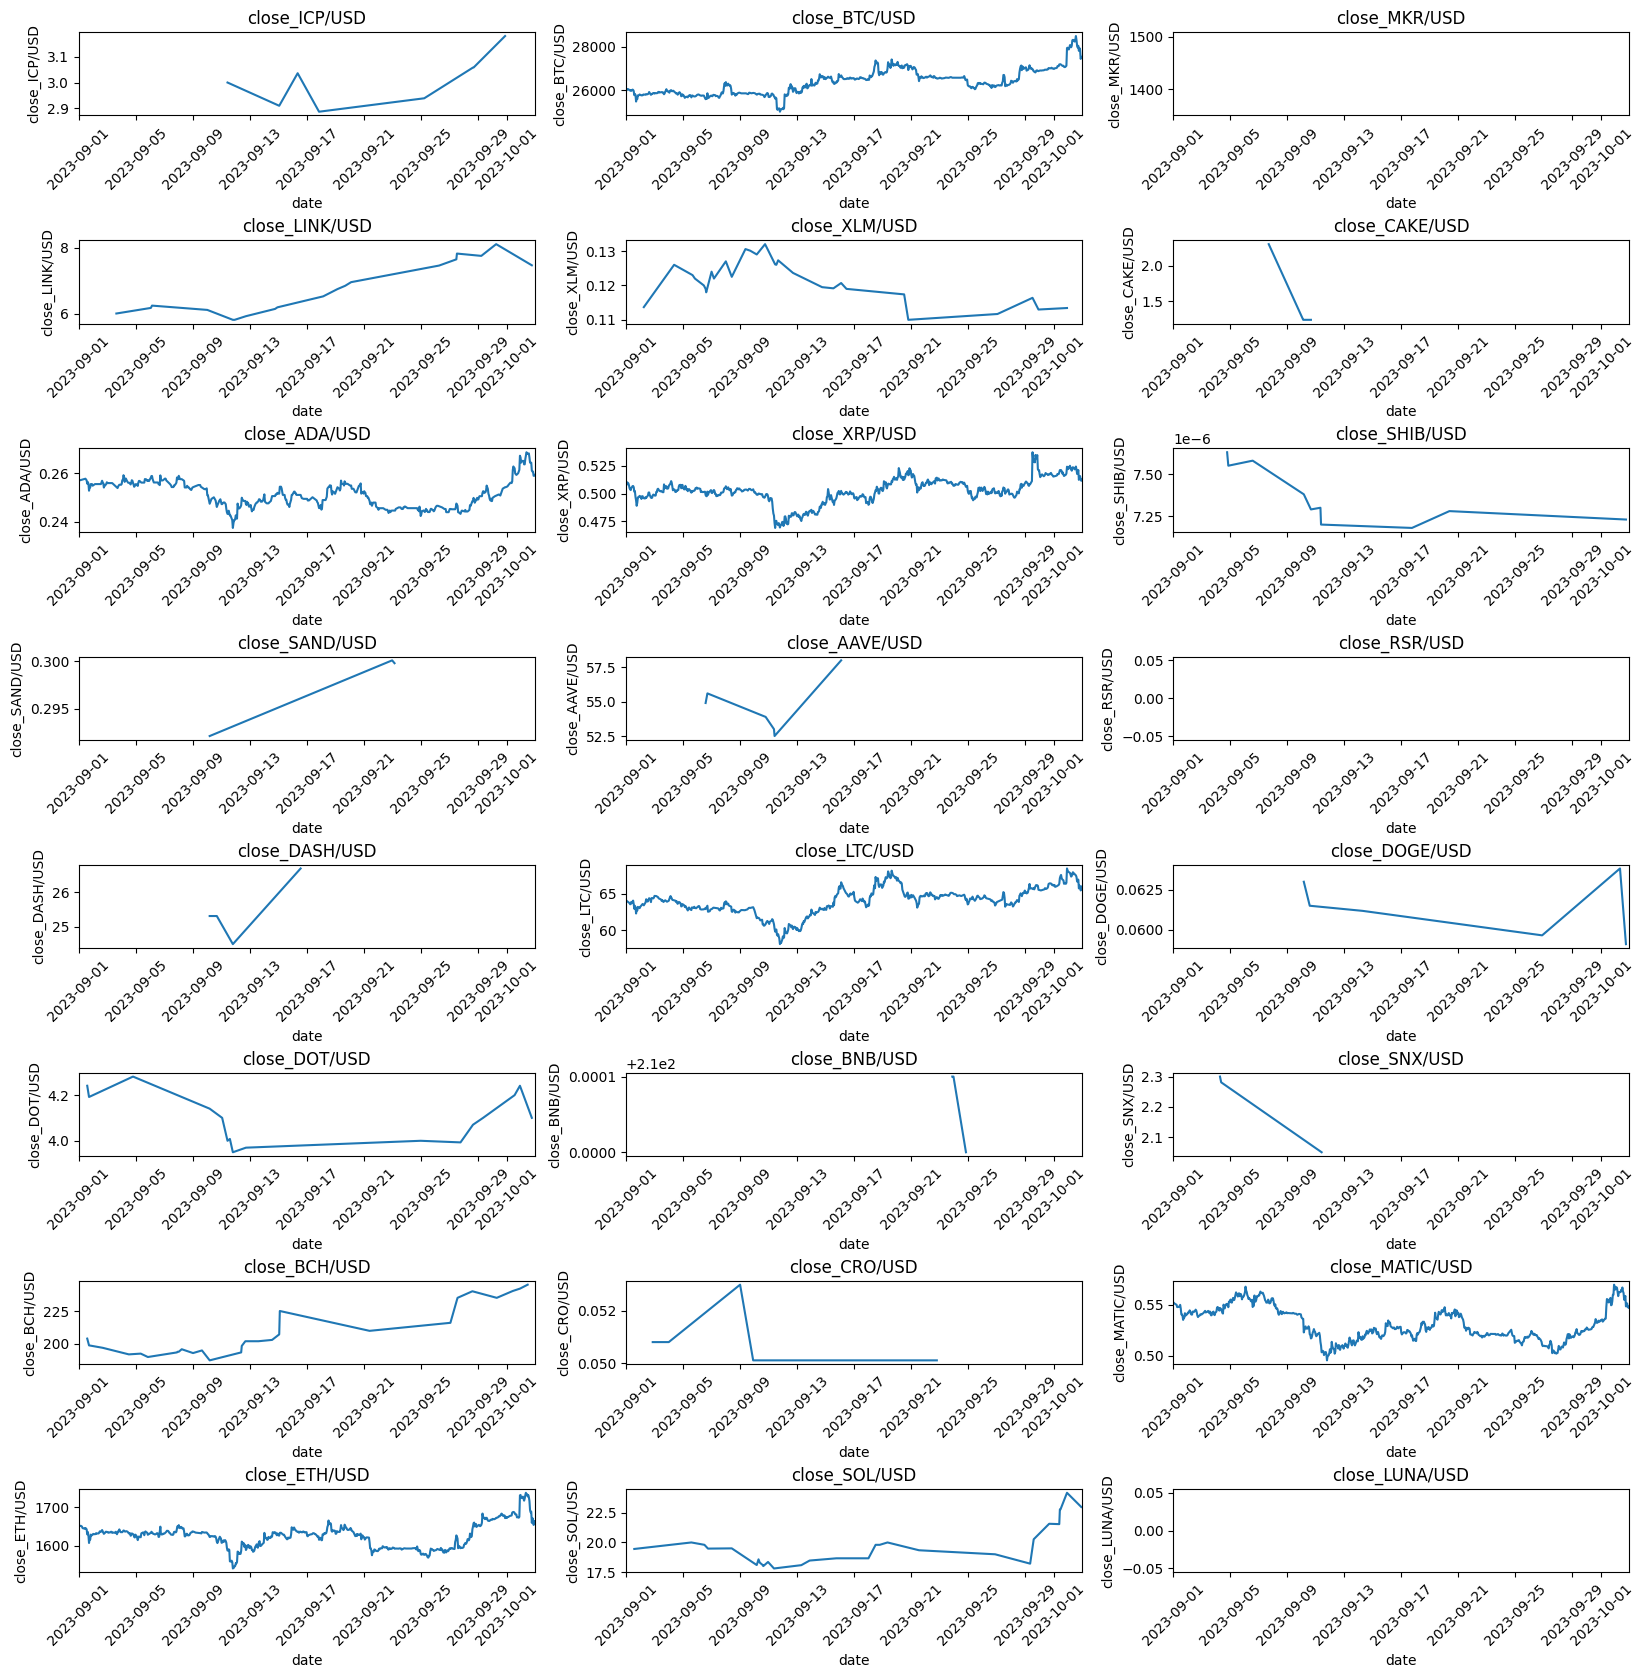

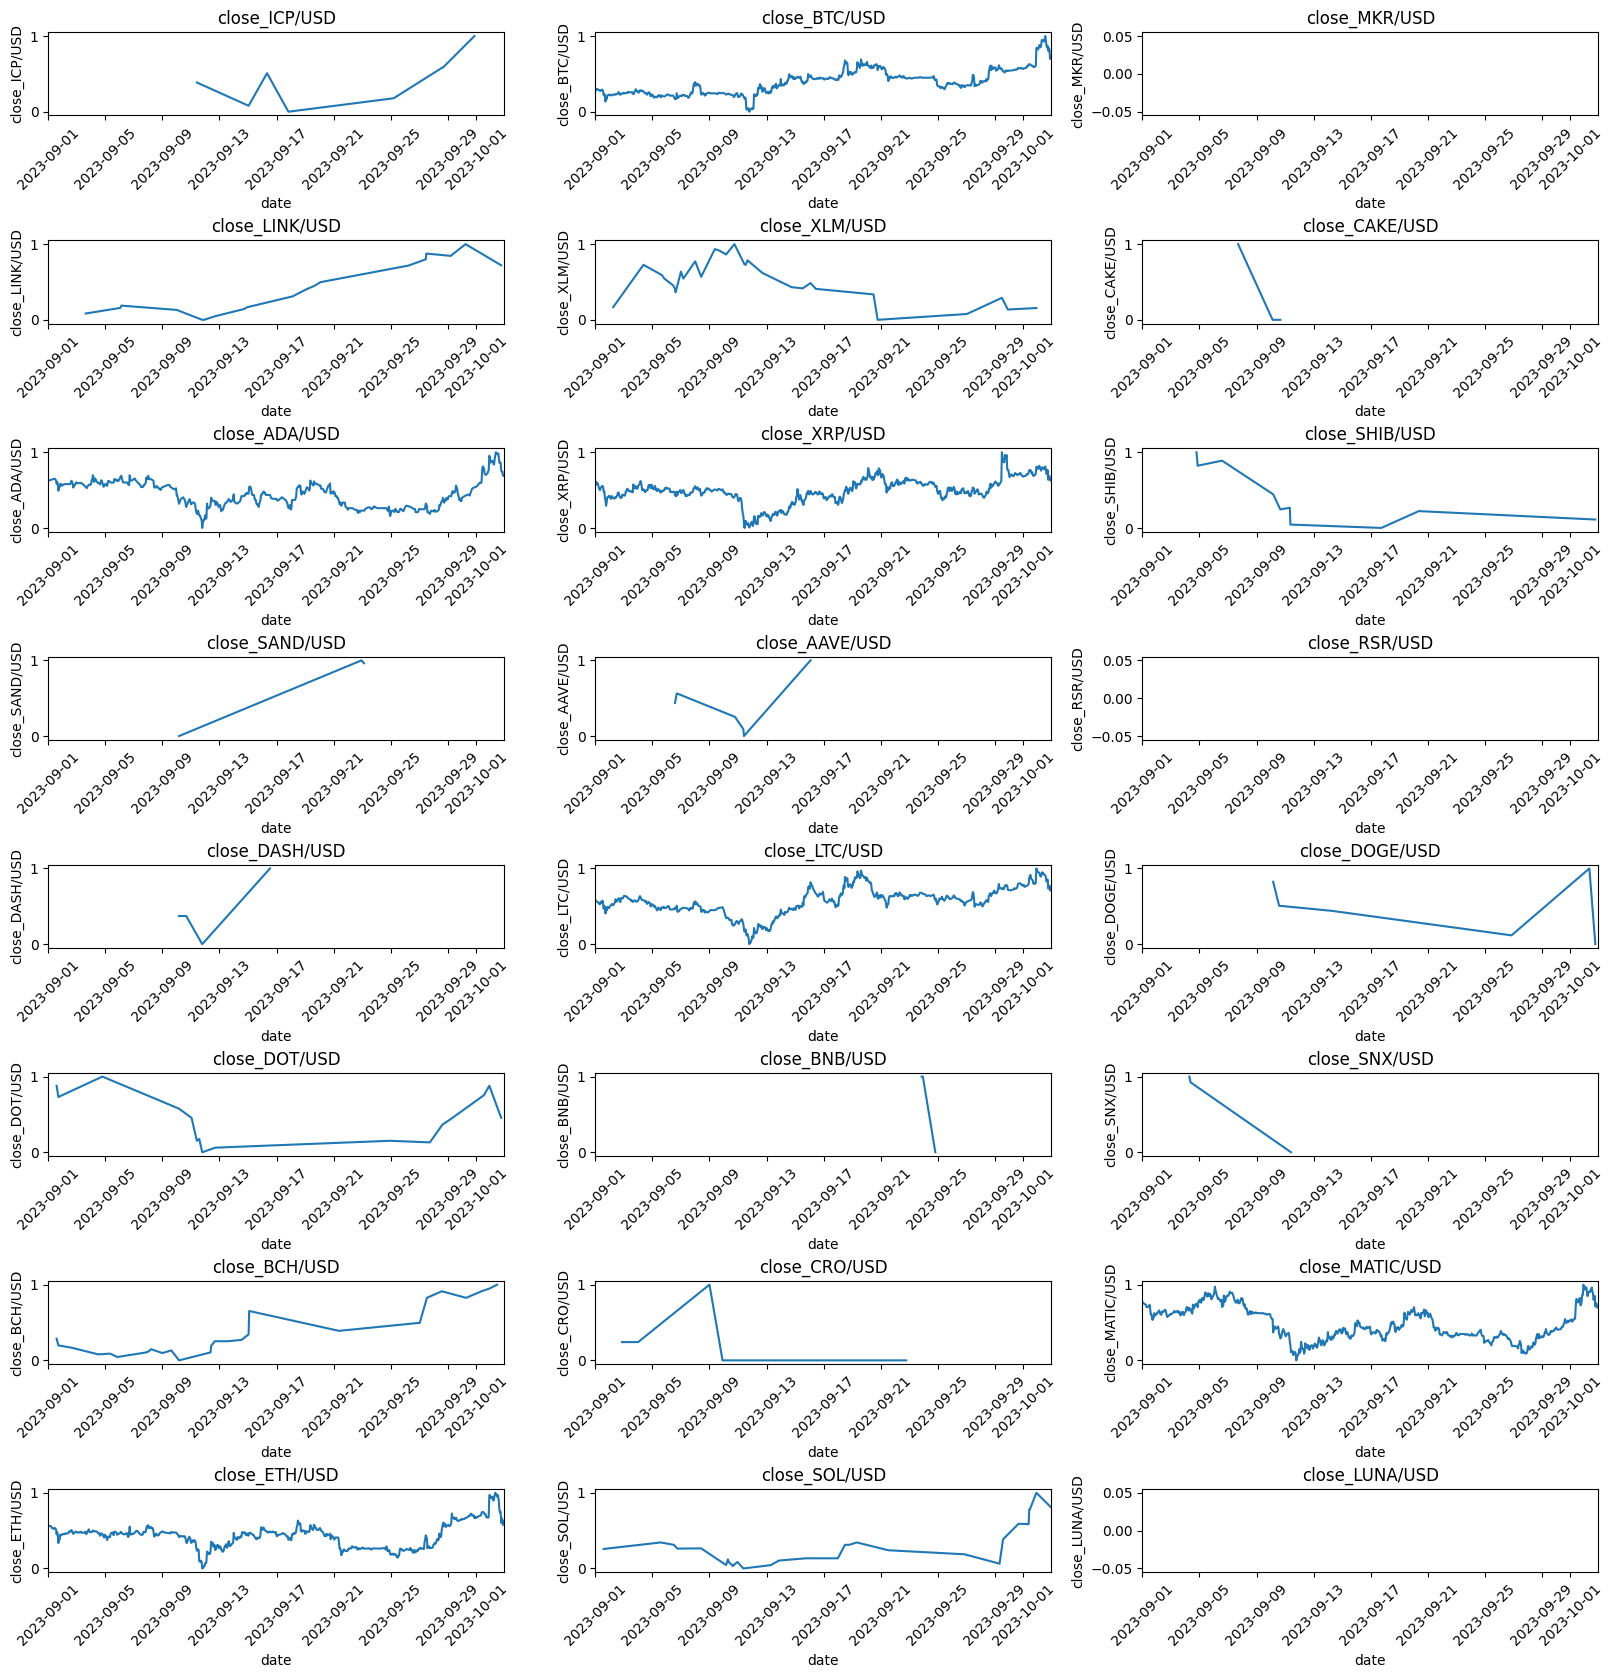

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(merged_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=merged_df, x="date", y=col, ax=ax)
    ax.set_title(col)

    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['date'].min(), merged_df['date'].max())

plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a custom Min-Max scaling function
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column

# Scale the numeric columns in the DataFrame (excluding 'date')
numeric_cols = merged_df.columns[1:]
scaled_df = merged_df.copy()
scaled_df[numeric_cols] = scaled_df[numeric_cols].apply(custom_min_max_scaling, axis=0)

# Create subplots with vertical space using Seaborn
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(8, 3, hspace=1.5)  # Adjust the value of hspace as needed

for i, col in enumerate(scaled_df.columns[1:]):
    ax = plt.subplot(grid[i // 3, i % 3])
    sns.lineplot(data=scaled_df, x="date", y=col, ax=ax)
    ax.set_title(col)

    # Rotate x-axis labels to an oblique angle
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Set x-axis limits to display the full date range
    ax.set_xlim(merged_df['date'].min(), merged_df['date'].max())


# Display the plots
plt.show()